<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/Failure_analysis_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Failure Analysis
### The best performing model: Histogram Gradient Boosting Regression Trees
- The primary focus of this notebook is to perform failure analysis.
- Since our dataset was relatively small considering the diversity of the word vector feature values in the n-dimensional featue space, the best value of the quality of fit we observed was only 37% after we leveraged cross validation along with grid search.
- That being said, Our failure analysis would be more like a success analysis to try and observe what we got right and why we think the model was able to pick that signal up.

In [51]:
!gdown 1PTaSiunxWhwkHxKf5v4G3oPbAXzvGqKN 
!gdown 1v8rbzAcb_cAw7kwShlGyEuAUw2Ja006N 
!gdown 1porOGWPwFdydbXbQQmveCPvAT1lvO8RC
!gdown 12uI3sXRLJzEwPx05D7tZD5g7DRAcAcFs

!gdown 1Nwp22QXlSRyczKxC_siWZQ10qm0WVKON

Downloading...
From: https://drive.google.com/uc?id=1PTaSiunxWhwkHxKf5v4G3oPbAXzvGqKN
To: /content/SIADS696/train_X.csv
100% 39.6M/39.6M [00:00<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v8rbzAcb_cAw7kwShlGyEuAUw2Ja006N
To: /content/SIADS696/train_y.csv
100% 733k/733k [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1porOGWPwFdydbXbQQmveCPvAT1lvO8RC
To: /content/SIADS696/test_X.csv
100% 9.92M/9.92M [00:00<00:00, 99.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=12uI3sXRLJzEwPx05D7tZD5g7DRAcAcFs
To: /content/SIADS696/test_y.csv
100% 183k/183k [00:00<00:00, 79.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nwp22QXlSRyczKxC_siWZQ10qm0WVKON
To: /content/SIADS696/model.sav
100% 749k/749k [00:00<00:00, 99.1MB/s]


In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pylab as pl

import datetime
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from matplotlib import ticker

import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [46]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

In [4]:
import gensim.downloader
glove_wv = gensim.downloader.load('glove-wiki-gigaword-50')

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
train_X = pd.read_csv("train_X.csv")
train_y = pd.read_csv("train_y.csv")

test_X_ = pd.read_csv("test_X.csv")
test_y = pd.read_csv("test_y.csv")

In [7]:
test_X_

,publishedDayNum,log_duration_secs,len_title,title_1,title_2,title_3,title_4,title_5,title_6,title_7,...,title_43,title_44,title_45,title_46,title_47,title_48,title_49,title_50,definition,topicLabel
0,55,6.448889,11,-0.067034,0.738506,0.354534,0.585256,0.500022,0.182586,0.032060,...,-0.288240,0.040508,-0.351104,0.022336,0.155882,-0.418398,0.254494,1.296076,hd,cooking
1,251,6.972606,7,-0.221372,0.771232,0.380841,0.853690,0.404392,0.200614,0.332160,...,-0.147374,-0.202466,-0.476051,-0.034336,0.299940,-0.610114,0.220954,1.359274,hd,cooking
2,48,5.438079,4,0.406600,0.690655,0.844660,0.765535,-0.488250,-0.024590,0.215335,...,-0.170345,-0.177065,0.053796,0.655165,0.211580,-0.266535,0.155870,1.839400,hd,music
3,213,6.403574,4,-0.023580,0.646470,0.802832,0.913045,0.340683,-0.067310,0.350050,...,0.031009,-0.097173,0.149332,0.322852,0.191959,-0.383737,0.603576,0.667638,hd,fitness
4,78,7.362645,4,-0.142713,0.801386,0.527906,0.778926,0.332370,-0.101727,0.372164,...,-0.139873,-0.176725,-0.054009,0.051937,0.046176,-0.625320,0.324756,1.211579,hd,history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9617,233,5.153292,9,-0.101717,1.059783,0.667565,1.030287,0.435890,-0.108123,0.809597,...,0.088013,-0.638757,-0.661797,-0.097090,0.161490,-0.651966,0.629860,1.137917,hd,music
9618,180,5.365976,3,-0.252733,0.884874,0.826581,0.984834,0.498031,-0.165098,0.698783,...,-0.207881,-0.115602,0.180434,0.153174,0.103049,-0.532818,0.432853,0.835500,hd,comedy
9619,47,6.272877,4,-0.265456,0.896224,0.619452,0.864880,0.513994,-0.257218,0.627414,...,-0.179184,-0.126249,-0.212088,0.284164,0.106127,-0.541855,0.567468,0.753146,hd,travel
9620,273,5.379897,3,-0.063648,1.082242,0.412049,0.797175,0.298542,0.039410,0.451043,...,-0.156935,-0.293163,-0.423686,-0.014855,0.144395,-0.701292,0.363572,1.089745,hd,comedy


In [53]:
ct = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
    ("poly", PolynomialFeatures(5),["publishedDayNum",	"log_duration_secs", "len_title"]),
    ], remainder="passthrough")

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X_)

mms = MinMaxScaler()
train_X = mms.fit_transform(train_X)
test_X = mms.transform(test_X)

In [10]:
hgbr = HistGradientBoostingRegressor(l2_regularization=0.2,
                              max_depth=10,
                              max_leaf_nodes=50,
                              n_iter_no_change=15)

In [11]:
hgbr.fit(train_X, train_y)

HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,
                              max_leaf_nodes=50, n_iter_no_change=15)

In [31]:
r2_score(test_y, hgbr.predict(test_X))

0.18405768565587954

Now, let's take a look at a very sample of the test data and look at a scatter plot of the closeness between the true and predicted values.

In [91]:
sample = np.random.permutation(test_X)[:60]

In [92]:
res_df = pd.DataFrame({'data_point#':list(np.arange(sample.shape[0])), 'true':list(test_y.values[:sample.shape[0]][:,0]), 'prediction':list(hgbr.predict(sample)[:sample.shape[0]])})

In [95]:
trace1 = go.Scatter(
    x=res_df["data_point#"],
    y=res_df['prediction'],
    name='prediction',
    mode='markers',
)
trace2 = go.Scatter(
    x=res_df["data_point#"],
    y=res_df['true'],
    name='true',
    mode='markers',

)

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=False)
fig['layout'].update(height = 600, width = 1300, title = "True vs predicted values closeness",xaxis=dict(
      tickangle=-55
    ))
fig

In [97]:
res_df.true.mean(), res_df.prediction.mean()

(1.898014998065459, 1.7586461849156592)

To get a higher degree of clarity on what's really happening, let's do some groupings on our dataset.

In [101]:
res_df['topicLabel']=test_X_['topicLabel']

In [102]:
res_df['diff'] = abs(res_df['true']-res_df['prediction'])

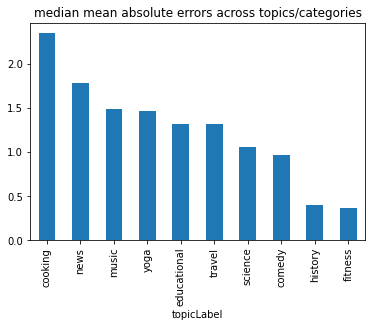

In [117]:
res_df.groupby('topicLabel')['diff'].agg('median').sort_values(ascending=False).plot(kind='bar')
plt.title("median mean absolute errors across topics/categories");

In [167]:
w2v_cols = ['title_'+str(i) for i in range(1, 51)]

In [166]:
test_X_[[w2v_cols[0]]+['topicLabel']].groupby('topicLabel').describe()

title_1                                                    \
              count      mean       std       min       25%       50%   
topicLabel                                                              
comedy       1007.0 -0.074306  0.164462 -0.557610 -0.186585 -0.094475   
cooking      1362.0 -0.070959  0.143145 -0.814060 -0.173812 -0.078839   
educational   990.0 -0.094075  0.128383 -0.493080 -0.186577 -0.103703   
fitness       926.0 -0.075305  0.152959 -0.557610 -0.159351 -0.087642   
history       768.0 -0.084423  0.129932 -0.943200 -0.155760 -0.094431   
music         692.0 -0.061454  0.154300 -0.462925 -0.158041 -0.082358   
news         1231.0 -0.096490  0.158808 -0.814060 -0.190977 -0.097350   
science       826.0 -0.087806  0.152203 -0.596605 -0.179610 -0.104834   
travel        846.0 -0.078890  0.146748 -0.661423 -0.179081 -0.081783   
yoga          974.0 -0.070618  0.129975 -0.493080 -0.150420 -0.082588   

                                 
                  75%       max  
topicLabel                       
comedy       0.014036  0.738330  
cooking      0.026794  0.379943  
educational -0.000613  0.441440  
fitness      0.003899  0.526690  
history     -0.016019  0.379943  
music        0.015937  0.406600  
news         0.004080  0.632510  
science     -0.000032  0.441440  
travel       0.012652  0.330722  
yoga        -0.016540  0.370893

In [225]:
pca = KernelPCA(n_components=1, kernel='poly', degree=5)
pca.fit(test_X_[w2v_cols])

KernelPCA(degree=5, kernel='poly', n_components=1)

In [205]:
x = pca.transform(test_X_[test_X_.topicLabel=='cooking'][w2v_cols])[:,0]
y = pca.transform(test_X_[test_X_.topicLabel=='cooking'][w2v_cols])[:,1]

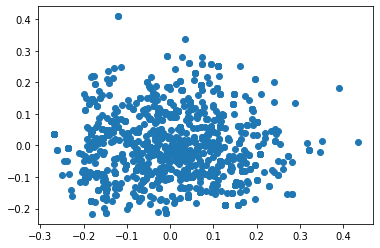

In [206]:
plt.scatter(x, y);

In [209]:
x = pca.transform(test_X_[test_X_.topicLabel=='fitness'][w2v_cols])[:,0]
y = pca.transform(test_X_[test_X_.topicLabel=='fitness'][w2v_cols])[:,1]

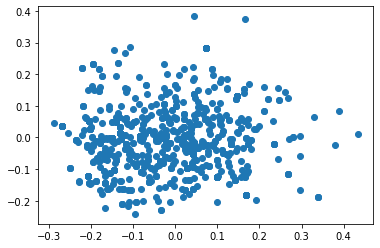

In [210]:
plt.scatter(x, y);

mean across labels With PC=1

In [226]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='cooking'][w2v_cols])).describe().loc['mean']

0    0.017089
Name: mean, dtype: float64

In [227]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='news'][w2v_cols])).describe().loc['mean']

0    0.030301
Name: mean, dtype: float64

In [230]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='music'][w2v_cols])).describe().loc['mean']

0   -0.038058
Name: mean, dtype: float64

In [231]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='yoga'][w2v_cols])).describe().loc['mean']

0    0.026005
Name: mean, dtype: float64

In [232]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='educational'][w2v_cols])).describe().loc['mean']

0   -0.001695
Name: mean, dtype: float64

In [233]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='travel'][w2v_cols])).describe().loc['mean']

0    0.035405
Name: mean, dtype: float64

In [234]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='science'][w2v_cols])).describe().loc['mean']

0   -0.027958
Name: mean, dtype: float64

In [228]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='fitness'][w2v_cols])).describe().loc['mean']

0   -0.035737
Name: mean, dtype: float64

In [229]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='history'][w2v_cols])).describe().loc['mean']

0    0.004801
Name: mean, dtype: float64

The above chart tells us that, across topics/categories, the model's performance is best for categories on the right(lower error is better) and worst on the left(higher error is worse)

In addition, We could also make a claim that selection of one of the categories amongst cooking, news, music would most likely throw the model farther away from the true value.

We'll try and validate the above claim with 3 values that visually show a large difference between the true an dpredicted value

In [118]:
static_sample = test_X[:60]

In [119]:
static_res_df = pd.DataFrame({'data_point#':list(np.arange(static_sample.shape[0])), 'true':list(test_y.values[:static_sample.shape[0]][:,0]), 'prediction':list(hgbr.predict(static_sample)[:static_sample.shape[0]])})

In [120]:
trace1 = go.Scatter(
    x=static_res_df["data_point#"],
    y=static_res_df['prediction'],
    name='prediction',
    mode='markers',
)
trace2 = go.Scatter(
    x=static_res_df["data_point#"],
    y=static_res_df['true'],
    name='true',
    mode='markers',

)

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=False)
fig['layout'].update(height = 600, width = 1300, title = "True vs predicted values closeness",xaxis=dict(
      tickangle=-55
    ))
fig

- From the above, Let's examine point #s 10, 19, 47 for the large errors and,
point #s 11, 23, 38 for their significantly small errors.
- (remember our hypothesis based on the above chart, points 10, 19, 47 are more likely to belong to groups on the left hand side of the barplot observed in the previous chart and points, 11, 23, 38 are more likely to belong to groups on the right)

In [127]:
test_X_.iloc[10].topicLabel, test_X_.iloc[19].topicLabel, test_X_.iloc[31].topicLabel

('cooking', 'cooking', 'news')

In [134]:
test_X_.iloc[11].topicLabel, test_X_.iloc[13].topicLabel, test_X_.iloc[38].topicLabel

('fitness', 'cooking', 'comedy')

- Our hypothesis does hold true in essence, as, the categoriesto the right seem to have predictions that are way off as compared to the ones on the left.
- An important observation to make note of is the ability of the cooking class to be really precise in some cases (like that of point #13). That brings us to the idea that it is likely that there could be more than just the underlying topicLabels that are responsible for throwing the prediction off.
- For the above reasons, let's take a closer look at the observations in the cooking category

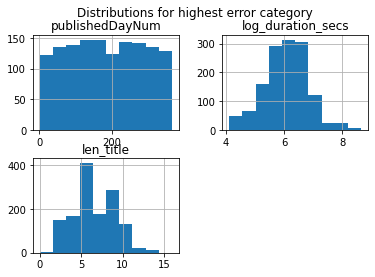

In [154]:
test_X_[test_X_.topicLabel=='cooking'][['publishedDayNum', 'log_duration_secs', 'len_title']].hist()
pl.suptitle("Distributions for highest error category");

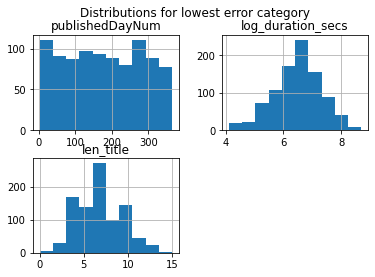

In [152]:
test_X_[test_X_.topicLabel=='fitness'][['publishedDayNum', 'log_duration_secs', 'len_title']].hist()
pl.suptitle("Distributions for lowest error category");

- A view into the distribution of these features, it is clear that there isn't an apparent difference that stands out amongst the best, worst performing topics/categories.
- Coupling this with the understanding that the definition contributed close to nothing <1% in the permutation importance stage, we are only left with the word vector representations as a possible explanation to the underlying problem.

Let's understand how the word vector representation could be the case.

- We incrementally, increased the complexity of the way we chose to do our title feature representation based on observed gains in performance. [count_vec->TFIDF->Word2Vec].
- While we note that the title, and the meta data available to us, don't really make an intuitive sense for these features being the at the core of the prediction of the title quality score.
There is a fundamental failure that prohibits the model from learning further without overfitting the training data:
  - The pre-trained word2vec model
  - It is easy to observe this from the analysis we carried out upto this point. i.e. we eliminated the possible involvement of other features as explained above.
  - The note we made above (from the bar chart) of the labels on the left, like `cooking` being markers of possibilities of high error predictions sheds light on what the shortcomings of the pretrained model could be. i.e. under the topic `cooking` the titles are more likely to use words that don't strictly obey the language construct and hence use words in a different meaning than they would generally be used in. (The pretrained model we used is that of a smaller generic wikipedia representation). linearity shoudn't be a problem because w2v models are very good at capturing high dimensional feature space info in a relatively smaller dimension space.
  - Categories like `fitness`, `history` tend to have words that are similar across variations e.g. "abs and core workout", "strengthen your core muscles", etc while categories like music seem to use similar words in a totally different context.
    1. To address the above failure, we'd have to pick a larger pretrained model that is ideally specific to the categories/topics.
    2. Another approach could be that of increasing the data from ~5.5k per topic/category to atleast 55k per category and then training a custom w2v model.
    3. To address varaiations, the bar chart we obtained could be a good point of start to obtain additional data based inversely proportional to the error rates, implying that we would as a result, be able to help the model justify variations instead of the model trying to overfit what now, would look like noise.

As things currently stand, the model would fail if the data that is fairly recent (newer `news`/`music`(song names)) and was not a part of the tranining of the pretrained model.
Since this accounts for ~53% of the model's explainability, this adjustment would definitely help mitigate the kind of failures we observed.

Some word:vector scope analysis

In [12]:
!git clone https://github.com/ajinkyabhanudas/SIADS696.git
!pip install gensim==4.1.2

In [13]:
try:
  os.chdir('SIADS696')
except:
  print("You're either already in the SIADS696 directory, or the path specified isn't accessible")

In [322]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories', 'topicLabel']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        temp_dict["topicLabel"] = path.split('/')[2]
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

In [20]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
### Miles code fix included here   
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  for i, val in enumerate(duration_split(duration)):
    
    if len(str(duration)) <= 8:
      if i==1 and not val.isalpha():
        temp += float(val)*60
      
      if i==3 and not val.isalpha():
        temp += float(val)
    else:
      if i==1 and not val.isalpha():
        temp += float(val)*60*60
      
      if i==3 and not val.isalpha():
        temp += float(val)*60
      
      if i==5 and not val.isalpha():
        temp += float(val)

  return(temp)


# duration_2_secs("PT51M12S")

In [21]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [22]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list

In [83]:
def gen_word_vec(df_text_list, wordvec):
    word_vector = []
    for token in df_text_list:
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in wordvec.key_to_index]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(wordvec[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(wordvec.vector_size))
    word_vector = np.array(word_vector)
    try:
      return word_vector[0]
    except:
      return np.zeros(50)

In [101]:
def word_vec_cnt(df_text_list, wordvec):
    token_vocab = []
    for token in df_text_list:
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [1 if i in wordvec.key_to_index else 0 for i in token_considered]
    
    return token_vocab

In [156]:
def miss_word(df_text_list, wordvec):
    token_vocab = []
    for token in df_text_list:
      
      token_considered = [t for t in token if t.isalpha]
      token_vocab = [1 for i in token_considered if i not in wordvec.key_to_index]
    try:
      res = len(token_vocab)/len(token_considered)
    except:
      res=1
    return res 

In [24]:
def outlier_thresh(df, up=True):
  q1, q3 = np.percentile(df,[25,75])
  iqr = q3-q1
  if up:
    res = q3+1.5*iqr
  else:
    res = q1-1.5*iqr
  return(res)

In [41]:
def create_train_dataset(df, featureset=None, d=5):
    df["publishedAt"] = pd.to_datetime(df.publishedAt)
    df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
    df['duration_secs'] = df.duration.astype(int)
    df['topicLabel'] = df.topicLabel.str.lower()
    df['title'] = df.title.apply(text_prep)
    df['len_title'] = df.title.apply(lambda x: len(x))
    df['log_duration_secs'] = np.log(df.duration_secs + 1)
    df.loc[df['topicLabel'] == 'fitness_workout', 'topicLabel'] = 'fitness'

    df['vec_title'] = df.title.apply(gen_word_vec, wordvec=glove_wv)
    titles = df.vec_title.apply(pd.Series).rename(columns={i - 1: "title_" + str(i) for i in range(1, 51)})

    train_X = pd.concat(
        [df[['publishedDayNum', 'log_duration_secs', 'len_title']], titles, df.definition, df.topicLabel],
        axis=1)
    return train_X

In [31]:
def title_check(df):
  
  df["publishedAt"] = pd.to_datetime(df.publishedAt)
  df['publishedDayDelta'] = (datetime.datetime.now() - df.publishedAt.dt.tz_localize(None)).dt.days
  df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
  df["viewCount"] = df.viewCount.astype(float)
  df["avg_viewCount"] = df["viewCount"]/df['publishedDayDelta']
  df['topicLabel'] = df.topicLabel.str.lower()
  df['score'] = df["avg_viewCount"]/df.topicLabel.map(dict(df.groupby('topicLabel').avg_viewCount.agg('median')))
  if df['duration'].dtype == 'O':
    df['duration_secs'] = df.duration.apply(duration_2_secs)
  else:
     df['duration_secs'] = df.duration.astype(int)
  df['topicLabel'] = df.topicLabel.str.lower()
  df['title_unchanged'] = df.title.str.lower()
  df['title'] = df.title.apply(text_prep)
  df['len_title'] = df.title.apply(lambda x: len(x))
  df['log_duration_secs'] = np.log(df.duration_secs+1)
  df.loc[df['topicLabel'] == 'fitness_workout', 'topicLabel'] = 'fitness'

  df['vec_title'] = df.title.apply(gen_word_vec, wordvec=glove_wv)
  titles = df.vec_title.apply(pd.Series).rename(columns={i-1:"title_"+str(i) for i in range(1,51)})
  high = dict(df.dropna().groupby('topicLabel').score.apply(outlier_thresh, up=True))
  low = dict(df.dropna().groupby('topicLabel').score.apply(outlier_thresh, up=False))
  df['high'] = df.topicLabel.map(high)
  df['low'] = df.topicLabel.map(low)
  df = df[df.score<=df.high]
  df = df[df.score>=df.low]
  

  df['vec_title'] = df.title.apply(gen_word_vec, wordvec=glove_wv)

  titles = df.vec_title.apply(pd.Series).rename(columns={i-1:"title_"+str(i) for i in range(1,51)})

  train_X = pd.concat([df[['publishedDayNum', 'log_duration_secs', 'len_title']], titles, df.title_unchanged, df.title, df.definition, df.topicLabel, df.score], axis=1)

  return train_X

In [230]:
cooking_df = raw_df[raw_df.topicLabel=='Cooking']

In [231]:
cooking_titles_df = title_check(cooking_df)

In [232]:
df = cooking_titles_df.drop(['title_unchanged', 'title'], axis=1)

In [233]:
df_X = df.drop('score', axis=1)
df_y = df['score']

In [61]:
# val_df = df_X.sample(20)

In [234]:
pred_df = ct.transform(val_df)
pred_df = mms.transform(pred_df)


In [66]:
temp_df = val_df.reset_index().reset_index()
temp_df['index'] = temp_df['index'].astype(str)

In [70]:
static_res_df = pd.DataFrame({'data_point_index':temp_df['index'], 'true':list(df_y[val_df.index]), 'prediction':list(hgbr.predict(pred_df))})

In [73]:
trace1 = go.Scatter(
    x=static_res_df["data_point_index"],
    y=static_res_df['prediction'],
    name='prediction',
    mode='markers',
)
trace2 = go.Scatter(
    x=static_res_df["data_point_index"],
    y=static_res_df['true'],
    name='true',
    mode='markers',

)

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=False)
fig['layout'].update(height = 600, width = 1300, title = "True vs predicted values closeness for the 'cooking' category",xaxis=dict(
      tickangle=-55
    ))
fig

- high error prediction indices: [45919, 44023, 50251]
- low error prediction indices: [44933, 43991]

In [81]:
cooking_titles_df.loc[[45919, 44023, 50251]][['title', 'title_unchanged']].style

,title,title_unchanged
45919,"['mongolian', 'beef', 'home', 'like', 'favorite', 'chinese', 'takeout', 'sam', 'cooking', 'guy']",mongolian beef at home but just like your favorite chinese takeout! | sam the cooking guy
44023,"['easy', 'authentic', 'sushi', 'hand', 'rolls', 'home', 'temaki']",easy authentic sushi hand rolls at home (temaki)
50251,"['eggs', 'benedict', 'ways', 'jamie', 'oliver']",eggs benedict | 5 ways | jamie oliver


- As we had guessed with the possible problems in the cooking category, we do notice a problem that could also contribute to the variations in other categories, that is of having names, unique-words that the model is just not able to meaningfully enrich into a relevant vector. These names that we see in 2/3 of the high error predictions could be of individuals who actually garner a lot of popularity in the space and as a result increase the views just with their name in the videos.
- Another hypothesis is that of words that are OOV (out of vocabulary). We'll try to validate it in this notebook further down.

In [82]:
cooking_titles_df.loc[[44933, 43991]][['title', 'title_unchanged']].style

,title,title_unchanged
44933,"['epic', 'chef', 'burger', 'challenge']",epic chef - burger challenge
43991,"['first', 'ever', 'beef', 'stroganoff', 'soup', 'dumpling', 'sailor', 'vs']",the first ever: beef stroganoff soup dumpling | sailor vs.


On the other end, the words in predictions that came out right are simple, frequently referenced and would most likely have been a part of the training process of the w2v wikipedia model we used.

Below is an example of a bad prediction which has also has a word that the word2vec model wasn't able to vectorise.

In [97]:
word_vec_cnt(cooking_titles_df.loc[[44023]].title, wordvec=glove_wv)

[1, 1, 1, 1, 1, 1, 0]

In [113]:
miss_word(cooking_titles_df.loc[[44023]].title, wordvec=glove_wv)

0.14285714285714285

In [118]:
type(cooking_titles_df.loc[[44023]].title)

pandas.core.series.Series

In [235]:
mean_val_cooking = []
for t in list(cooking_titles_df.index):

  mean_val_cooking.append(miss_word(cooking_titles_df.loc[[t]].title, wordvec=glove_wv))

In [237]:
pred_df = ct.transform(df_X)
pred_df = mms.transform(pred_df)

preds = hgbr.predict(pred_df)

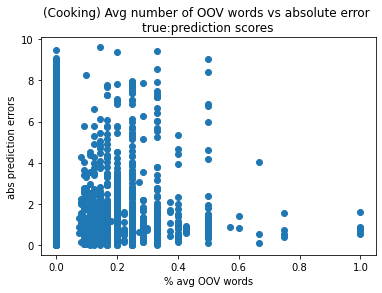

In [241]:
plt.scatter(mean_val_cooking, abs(df_y-preds));
plt.title("(Cooking) Avg number of OOV words vs absolute error \ntrue:prediction scores");
plt.xlabel("% avg OOV words")
plt.ylabel("abs prediction errors");

Now let's check if the chart above is similar to a sample of the entire dataset, If the chart looks similar, we could imply that OOV words don't play as profound a role that we hypothesized. Because, if that were true, we'd see predictions getting worse as the x-axis values go to one we'd see higher errors, which clearly is not the case. Hence, the OOV words don't play as much of a role.

In [222]:
all_df = title_check(raw_df.sample(10000))

In [224]:
mean_val_all = []
for t in list(all_df.index):

  mean_val_all.append(miss_word(all_df.loc[[t]].title, wordvec=glove_wv))

In [225]:
all_df_ = all_df.drop(['title_unchanged', 'title'], axis=1)

In [226]:
df_X = all_df_.drop('score', axis=1)
df_y = all_df_['score']

pred_df_ = ct.transform(df_X)
pred_df_ = mms.transform(pred_df_)


In [227]:
preds = hgbr.predict(pred_df_)

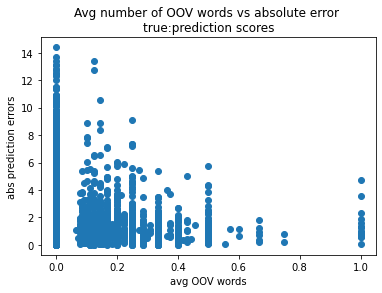

In [229]:
plt.scatter(mean_val_all, abs(df_y-preds));
plt.title("Avg number of OOV words vs absolute error \ntrue:prediction scores");
plt.xlabel("avg OOV words")
plt.ylabel("abs prediction errors");

The above chart is very similar to the previous chart that only contans the cooking category, which tell us that the OOV words in some cases are preventing the model from being thrown off. i.e. the word-vector representations are actually less meaningful irrespective of the topic they belongs to.

We'll examine the following next:
- the existence of view bias per topic i.e. we'll supply a random sequence eg. "QASDF" as the title name (which would have 100% oov rate and look at the views prediction across all categories)

In [263]:
raw_df.topicLabel.unique()

array(['Comedy', 'Travel', 'News', 'Music', 'Fitness_workout', 'Science',
       'Educational', 'Yoga', 'Cooking', 'History'], dtype=object)

In [275]:
test_row = raw_df.sample(1).copy()
test_row['title']="QASDF"

test_rows_df = pd.concat([test_row]*10)
test_rows_df = test_rows_df.reset_index().drop('index', axis=1)
test_rows_df['topicLabel'] = raw_df.topicLabel.unique()

test_rows_df_ = title_check(test_rows_df)

test_rows_df_ = test_rows_df_.drop(['title_unchanged', 'title'], axis=1)
test_rows_df_ = test_rows_df_.drop('score', axis=1)

pred_test_rows_df = ct.transform(test_rows_df_)
pred_test_rows_df = mms.transform(pred_test_rows_df)


In [277]:
test_rows_df['preds'] = hgbr.predict(pred_test_rows_df)

In [279]:
test_rows_df[['topicLabel', 'preds']].sort_values('preds')

,topicLabel,preds
8,cooking,1.334457
0,comedy,1.375263
9,history,1.592360
7,yoga,1.600623
4,fitness,1.619039
6,educational,1.941707
3,music,1.977677
2,news,2.037072
1,travel,2.448617
5,science,2.793945


The above table gives us an important insight on the effect of choosing a particular topicLabel. For example, if you type in a title with giberish, because we'd have an OOV rate of 100%, the quality score would be the highest, if the choice of the topic was science and lowest if the topic was cooking.
This is the inherent bias our model has learnt for each topic.

This is an interesting observation. This means that cooking has the lowest bias i.e. relies more on the nature of the word vectors and also is a category that could use words in a context that the pretrained model wasn't exposed to. These along with popularity key-words like names of celebrity chefs would easily lead to high error variations in the model.

One final failure check is the one to throw our model completely off by trying to make it give us the highest number of views with a meaningless title, which in reality wouldn't be likely to get a high number of views even if it existed.
Let's stick to one of the scores that is high and has a relatively low prediction error in the cooking category for this example so we can compare better.

In [281]:
cooking_df = raw_df[raw_df.topicLabel=='Cooking']
cooking_titles_df = title_check(cooking_df)

# test_rows_df_ = title_check(test_rows_df)

# test_rows_df_ = test_rows_df_.drop(['title_unchanged', 'title'], axis=1)
# test_rows_df_ = test_rows_df_.drop('score', axis=1)

# pred_test_rows_df = ct.transform(test_rows_df_)
# pred_test_rows_df = mms.transform(pred_test_rows_df)


In [285]:
max_score = max(cooking_titles_df.score)

In [303]:
cooking_titles_df.loc[43456][['title_unchanged', 'title', 'score']]

title_unchanged    binging with babish: together breakfast from s...
title              [binging, babish, together, breakfast, steven,...
score                                                       8.685785
Name: 43456, dtype: object

In [304]:
raw_df.loc[43456]

publishedAt                                     2021-03-23T13:00:03Z
title              Binging with Babish: Together Breakfast from S...
channelId                                   UCJHA_jMfCvEnv-3kRjTCQXw
description        This video is sponsored by Thrive Market. You'...
channelTitle                                Babish Culinary Universe
tags               [together breakfast, steven universe, together...
categoryId                                                        24
viewCount                                                    1482736
likeCount                                                      61250
favoriteCount                                                      0
commentCount                                                    2447
duration                                                     PT6M36S
definition                                                        hd
contentRating                                                     {}
topicCategories    [https://en.wik

In [ ]:
raw_copy = raw_df.copy()
raw_copy.loc[43456]

Let's try to hack this title down

In [360]:
cooking_df = raw_df[raw_df.topicLabel=='Cooking']
cooking_df.loc[43456].title= "Binging with from Steven :SCAMMING with WORDS from Steven Universe "
cooking_titles_df = title_check(cooking_df)

In [316]:
# row_df_ = cooking_titles_df.copy()
# row_df_ = row_df_.drop(['title_unchanged', 'title'], axis=1)
# row_df = row_df_.drop('score', axis=1)
# row_df = row_df.loc[43456]
# pred_row = ct.transform(pd.DataFrame(row_df).T)
# pred_row = mms.transform(pred_row)
# hgbr.predict(pred_row)
###ORIGINAL PREDICTION WITHOUT ALTERING THE TITLE

array([7.93521008])

At prediction time the model predicts this video to get ~8x more popularity than the median within this category. No let's use these words and construct in an attempt to construct something that wouldn't be as meaninful as the original title.

In [317]:
raw_df.loc[43456].title

'Binging with Babish: Together Breakfast from Steven Universe'

In [361]:
## with title "Binging with from Steven :SCAMMING with WORDS from Steven Universe "

row_df_ = cooking_titles_df.copy()
row_df_ = row_df_.drop(['title_unchanged', 'title'], axis=1)
row_df = row_df_.drop('score', axis=1)
row_df = row_df.loc[43456]
pred_row = ct.transform(pd.DataFrame(row_df).T)
pred_row = mms.transform(pred_row)
hgbr.predict(pred_row)

array([7.93521008])

Finding: Through our attempt to hack the model down, we accidentally came up with a title name that our model says would have exactly the same quality score even with a completely meaningless tiltle, just by making sure we use words in an order preserving manner.

In [365]:
cooking_df = raw_df[raw_df.topicLabel=='Cooking']
cooking_df.loc[43456].title= "Breakfast with Steven Universe: Binging with Babish "
cooking_titles_df = title_check(cooking_df)

In [366]:
## with title "Breakfast with Steven Universe: Binging with Babish"

row_df_ = cooking_titles_df.copy()
row_df_ = row_df_.drop(['title_unchanged', 'title'], axis=1)
row_df = row_df_.drop('score', axis=1)
row_df = row_df.loc[43456]
pred_row = ct.transform(pd.DataFrame(row_df).T)
pred_row = mms.transform(pred_row)
hgbr.predict(pred_row)

array([1.79317793])

Finding: This implies that our model wouldn't do as well, if the grammatical construction of video titles is characteristic of a particular demographic. This if not accounted for, would definitely bias the model to treat a demographic language construct superior to another without explicitly training the model for it.

Summary: With this we can summarise that we've done a failure analysis on topic-wise variance, the role of OOV words, the bias per topic that would lead to prediction failure, and finally another situation where our model would fail given an altered language construct. we also observed situations in the general data where the w2v models vectorisation wouldn't suit the context of the underlying topic and thus would lead to a higher error prediction.

In [ ]:
################# END OF THE FAILURE ANALYSIS NOTEBOOK ###############